In [20]:
from osa_pinn import bbnn, osa_pinn_sdof, normalise
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch

import time as clock_time

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

def select_alt(data, inds):
    mask = torch.ones_like(data, dtype=torch.bool)
    mask[inds]=False
    return data[mask]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
result_data = torch.load('results/osa_rpms_linear.pth')
osa_config = result_data['osa_config']

# result_data = {
#     'epoch' : i,
#     'gt_config' : config,
#     'osa_config' : osa_config,
#     'model' : osa_model.state_dict(),
#     'loss' : loss_hist,
#     'ground_truth' : ground_truth,
#     'data' : data,
#     'prediction' : prediction,
#     'alphas' : alphas
# }
nt = 2048
time = np.linspace(0,240,nt)

In [22]:
gt_config = result_data['gt_config']

Number of estimates in time: 2047
Maximum compute time: 3.8030e-05s
RMSE: 1.4055e-03


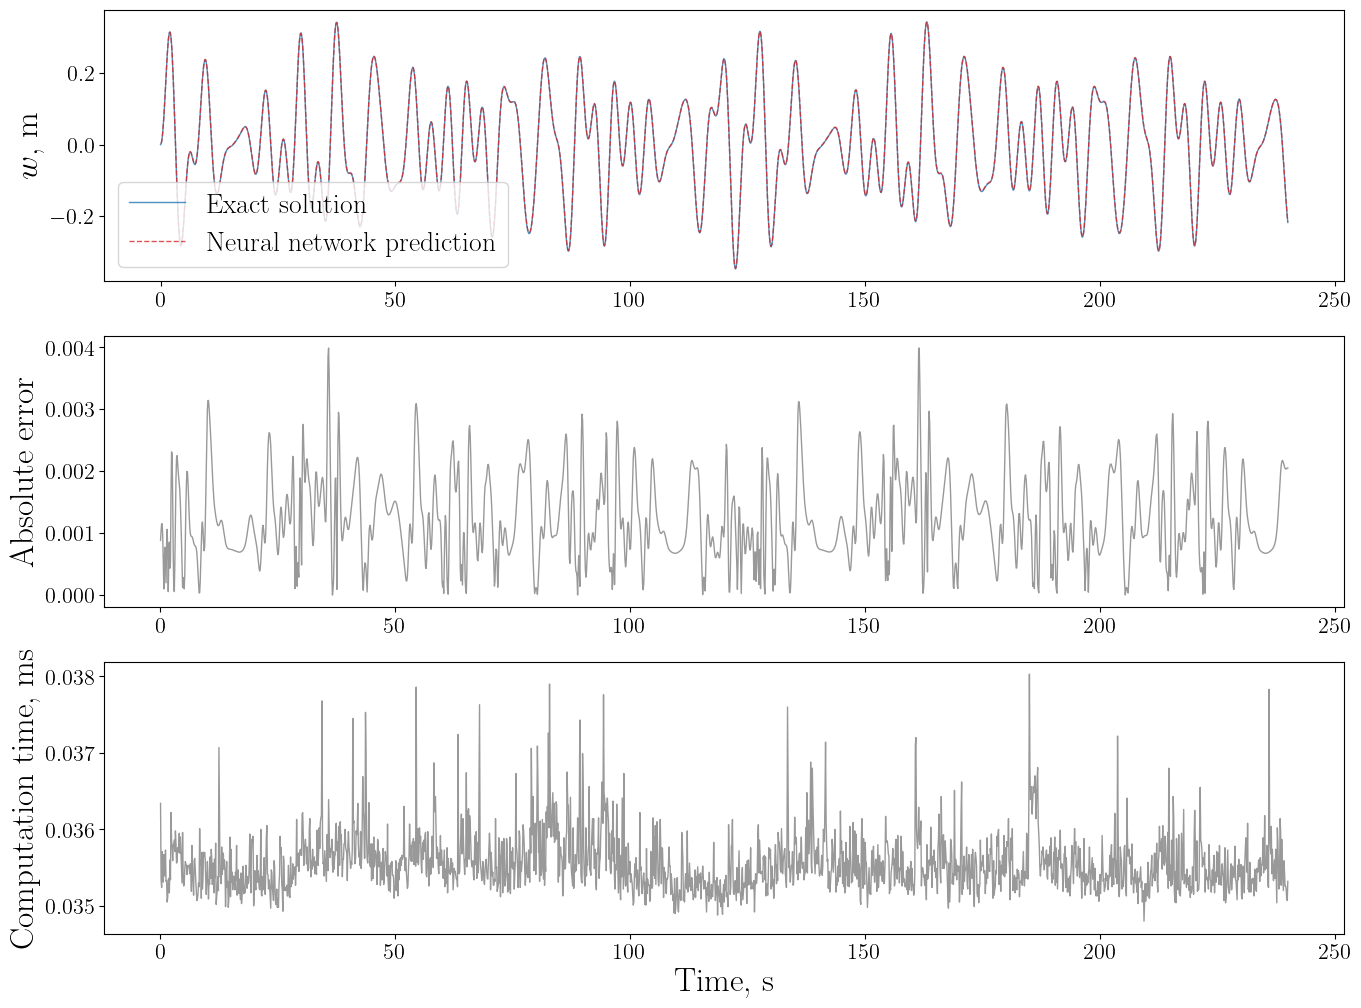

In [23]:
t_hat_gt = result_data['ground_truth']['t_hat'].squeeze()
x_hat_gt = result_data['ground_truth']['x_hat'].squeeze()
v_hat_gt = result_data['ground_truth']['v_hat'].squeeze()
F_hat_gt = result_data['ground_truth']['F_hat'].squeeze()

alpha_t = osa_config['alphas']['t']
alpha_x = osa_config['alphas']['x']
alpha_v = osa_config['alphas']['v']
alpha_F = osa_config['alphas']['F']

# t_data = result_data['data']['t_hat'].squeeze()
# x_data = result_data['data']['x_hat'].squeeze()
# v_data = result_data['data']['v_hat'].squeeze()
# F_data = result_data['data']['F_hat'].squeeze()
# sub_ind_train = result_data['data']['sub_ind']

# t_test = select_alt(t_hat_gt, sub_ind_train).squeeze()
# x_test = select_alt(x_hat_gt, sub_ind_train).squeeze()
# v_test = select_alt(v_hat_gt, sub_ind_train).squeeze()
# F_test = select_alt(F_hat_gt, sub_ind_train).squeeze()

t_test = t_hat_gt[:-1]
x0_test = x_hat_gt[:-1]
v0_test = v_hat_gt[:-1]
f0_test = F_hat_gt[:-1]
x_obs = x_hat_gt[1:]
T_hat = t_hat_gt[1].item() - t_hat_gt[0].item()
T = T_hat * alpha_t

osa_model = osa_pinn_sdof(osa_config)
osa_model.load_state_dict(result_data['model'])

n_test = t_test.shape[0]
err = [0] * n_test
cp_times = [0] * n_test
in_time = [False] * n_test
x_pred = [0] * n_test

# get many clock times for averaging
cp_times = np.zeros((n_test, 100))

for j in range(100):

    for i in range(n_test):

        x_true = x_obs[i] * alpha_x

        st = clock_time.process_time()

        x_pred[i] = osa_model.predict_new(x0_test[i], v0_test[i], T_hat, f0_test[i]).detach() * alpha_x

        et = clock_time.process_time()

        err[i] = x_pred[i].item() - x_true.item()
        cp_times[i,j] = et - st

        # in_time[i] = cp_times[i,j] < T

cp_times = np.mean(cp_times,axis=1)
in_time = cp_times < T.item()
        
fig, axs = plt.subplots(3, 1, figsize=(16,12))
axs[0].plot(time, x_hat_gt*alpha_x, color="tab:blue", linewidth=1, alpha=0.8, label="Exact solution")
axs[0].plot(time[1:], x_pred, color="tab:red", linestyle="--", linewidth=1, alpha=0.8, label="Neural network prediction")
# axs[0].set_xlabel("Time, s", fontsize=24)
axs[0].set_ylabel("$w$, m", fontsize=24)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=20)

axs[1].plot(time[1:], np.abs(err), color="grey", linewidth=1, alpha=0.8)
# axs[1].set_xlabel("Time, s", fontsize=24)
axs[1].set_ylabel("Absolute error", fontsize=24)
axs[1].tick_params(axis='both', which='major', labelsize=16)

axs[2].plot(time[1:], np.array(cp_times)*1e3, color="grey", linewidth=1, alpha=0.8)
axs[2].set_xlabel("Time, s", fontsize=24)
axs[2].set_ylabel("Computation time, ms", fontsize=24)
axs[2].tick_params(axis='both', which='major', labelsize=16)

# axs[0].plot(time[:-1], err)
# axs[0].set_yscale('log')
# axs[0].set_ylim((0,10))
# axs[0].plot(time[:-1],x_pred)
# axs[1].plot(cp_times)
# axs[0].plot(t_data,x_data)
# axs[1].plot(t_test,x_test)

RMSE = np.sqrt(np.mean(np.array(err)**2))
num_in_time = np.sum(in_time)
max_comp_time = np.max(cp_times)

print("Number of estimates in time: %d\nMaximum compute time: %.4es\nRMSE: %.4e" % (num_in_time, max_comp_time, RMSE))